# Network construction

We construct a network from the baseline Facebook Movement Maps data and obtain our baseline network as the largest strongly connected component (LSCC). We then compute daily networks on the same set of nodes from the Facebook Movement Maps for 10 March 2020 to 18 July 2020.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import numpy as np
import math
from geopandas.tools import sjoin
import shapely
from shapely.geometry import Point
import mercantile
from shapely.geometry import shape
import networkx as nx
import scipy
import scipy.sparse as sp
import pickle
from functools import partial
import seaborn as sns
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
from pathlib import Path
path = str(Path.cwd().parents[0])

module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)

from network_analysis import remove_self_loops, visualse_largest_components

root_figure = path+"/figures/"
root_map = path+'/data/geo_shapefiles//NUTS_Level_3__January_2018__Boundaries-shp/NUTS_Level_3__January_2018__Boundaries.shp'
root_baseline_data = path+'/data/fb_movement_maps/BETWEEN_TILES_BASELINE.csv'
root_timeseries_data = path+'/data/fb_movement_maps/BETWEEN_TILES_TRIP_NUMBERS.csv'
root_processed = path+"/data/processed/"
root_networks = path+"/data/processed/networks/"

In [3]:
plt.rcParams.update({'font.size': 20})

## Tile filtering
We determine here all geographic tiles from the Facebook Movement Maps that are located in the UK by comparing to shape files of the UK geography.

In [4]:
# load baseline mobility data
df_data = pd.read_csv(root_baseline_data)
df_data.head()

,start_quadkey,end_quadkey,Friday_0000,Friday_0800,Friday_1600,Monday_0000,Monday_0800,Monday_1600,Saturday_0000,Saturday_0800,...,Sunday_1600,Thursday_0000,Thursday_0800,Thursday_1600,Tuesday_0000,Tuesday_0800,Tuesday_1600,Wednesday_0000,Wednesday_0800,Wednesday_1600
0,31112312303,31112312303,20.0,13.6,13.8,19.0,11.6,14.8,21.2,22.4,...,23.2,17.50,12.00,13.50,19.0,12.8,15.4,20.2,11.0,11.8
1,31112312323,31112312323,29.8,19.4,23.4,29.6,16.4,23.0,26.2,25.4,...,35.8,30.25,18.75,20.75,30.4,18.2,23.6,30.0,17.6,20.0
2,31112321111,31112321111,NaN,NaN,NaN,10.2,NaN,NaN,10.8,10.2,...,11.6,NaN,NaN,NaN,10.2,NaN,NaN,10.4,NaN,NaN
3,31112321113,31112321113,21.0,14.6,16.4,21.2,12.6,15.4,19.8,18.8,...,25.6,18.50,15.50,17.25,19.8,11.2,15.0,20.0,12.6,13.6
4,31112321130,31112321130,72.2,57.6,64.4,71.0,51.8,65.8,68.2,63.4,...,80.8,70.50,52.25,64.25,68.4,51.6,66.6,73.8,55.4,67.4


In [5]:
# extract start and end quadkeys
df = pd.DataFrame({"start_quadkey": df_data["start_quadkey"], "end_quadkey" : df_data["end_quadkey"]})
df.to_csv(root_processed+"base_quadkeys.csv")

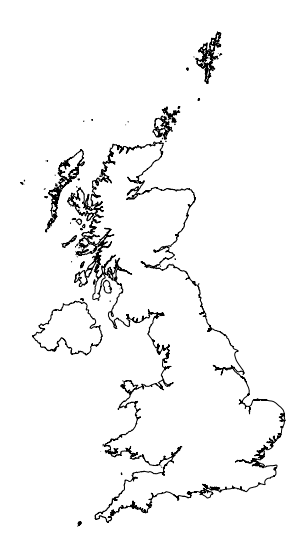

In [6]:
#######################
# Load map shape file #
#######################

map_df = gpd.read_file(root_map)
map_df['DUMMY'] = 1
# Dissovle to one shape
map_df2 = map_df.dissolve(by='DUMMY')
plt.rcParams['patch.force_edgecolor'] = True
plt.rcParams['patch.facecolor'] = 'b'
map_df = map_df.to_crs("EPSG:3395")
map_df2 = map_df2.to_crs("EPSG:3395")

# Plot the map to show we have created boundary
f, ax = plt.subplots(1, figsize=(15, 10))
ax = map_df2.plot(linewidth=1, ax=ax, facecolor = 'none')
ax.set_axis_off()
plt.show()

###################
# Load tiles data #
###################

df = pd.read_csv(root_processed+"base_quadkeys.csv")

# Converting the quadkeys to strings
df['start_quadkey'] = df['start_quadkey'].astype(str)
df['end_quadkey'] = df['end_quadkey'].astype(str)
# adding a leading '0' to quadkeys beginning with 3 so it maps on to web mercator
df.loc[df['start_quadkey'].str[:1] == '3', 'start_quadkey'] = '0'+df['start_quadkey']
df.loc[df['end_quadkey'].str[:1] == '3', 'end_quadkey'] = '0'+df['end_quadkey']
# Replace nan by 0
df = df.fillna(0)
# Get the first two quadkey columns
df_key = df.iloc[:,:2]

# Now make a list of all quadkeys in the dataset (whether start or end)
quadkeys = list(set(list(df['start_quadkey'])+list(df['end_quadkey'])))
polys = []

# Iterate over all quadkeys to create corresponding polygons
for quadkey in quadkeys:
    tile = mercantile.feature(mercantile.quadkey_to_tile(quadkey), projected = 'web mercator')
    polys.append(tile.get('geometry'))
geom = [shape(i) for i in polys]
gdf = gpd.GeoDataFrame({'geometry':geom, 'quadkey':quadkeys}, crs = "EPSG:4326")
gdf = gdf.to_crs("EPSG:3395")

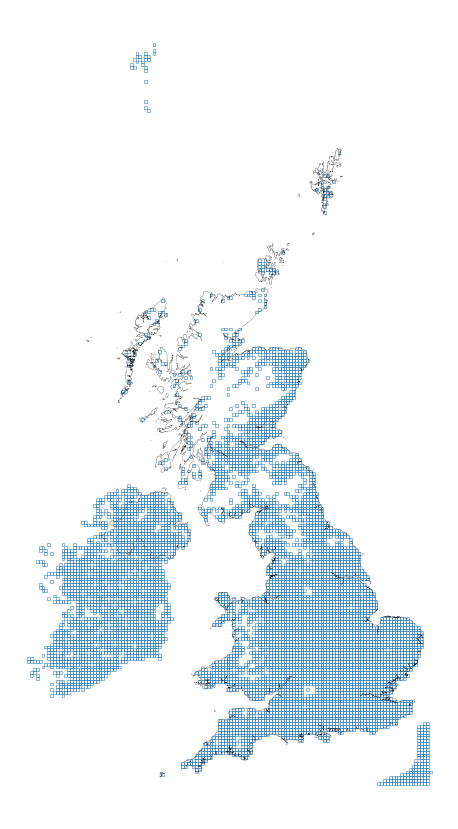

In [7]:
# Plot all quadkeys
fig, ax = plt.subplots(1, figsize=(10, 15))
ax = gdf.plot( alpha = 1, linewidth = 0.5, edgecolor='tab:blue', facecolor = 'none', ax=ax)
ax = map_df2.plot(linewidth=0.2, ax=ax, facecolor = 'none')
ax.set_axis_off()
plt.show()
fig.savefig(root_figure+'tiles_overlay.svg', dpi=fig.dpi,bbox_inches='tight')

In [8]:
def filter_tiles(root_map,root_baseline_data):
    '''
    input: root to shape file of country, root to movement between tiles data
    output: quadkeys of tiles within boundary of country
    
    Code partially developed by Jonny
    
    '''
    
    #######################
    # Load map shape file #
    #######################
    
    map_df = gpd.read_file(root_map)
    map_df['DUMMY'] = 1
    # Dissovle to one shape
    map_df2 = map_df.dissolve(by='DUMMY')
    plt.rcParams['patch.force_edgecolor'] = True
    plt.rcParams['patch.facecolor'] = 'b'
    map_df = map_df.to_crs("EPSG:3395")
    map_df2 = map_df2.to_crs("EPSG:3395")

    # Plot the map to show we have created boundary
    f, ax = plt.subplots(1, figsize=(15, 10))
    ax = map_df2.plot(linewidth=1, ax=ax, facecolor = 'none')
    ax.set_axis_off()
    plt.show()

    ###################
    # Load tiles data #
    ###################

    df = pd.read_csv(root_baseline_data)

    # Converting the quadkeys to strings
    df['start_quadkey'] = df['start_quadkey'].astype(str)
    df['end_quadkey'] = df['end_quadkey'].astype(str)
    # adding a leading '0' to quadkeys beginning with 3 so it maps on to web mercator
    df.loc[df['start_quadkey'].str[:1] == '3', 'start_quadkey'] = '0'+df['start_quadkey']
    df.loc[df['end_quadkey'].str[:1] == '3', 'end_quadkey'] = '0'+df['end_quadkey']
    # Replace nan by 0
    df = df.fillna(0)
    # Get the first two quadkey columns
    df_key = df.iloc[:,:2]

    # Now make a list of all quadkeys in the dataset (whether start or end)
    quadkeys = list(set(list(df['start_quadkey'])+list(df['end_quadkey'])))
    polys = []

    # Iterate over all quadkeys to create corresponding polygons
    for quadkey in quadkeys:
        tile = mercantile.feature(mercantile.quadkey_to_tile(quadkey), projected = 'web mercator')
        polys.append(tile.get('geometry'))
    geom = [shape(i) for i in polys]
    gdf = gpd.GeoDataFrame({'geometry':geom, 'quadkey':quadkeys}, crs = "EPSG:4326")
    gdf = gdf.to_crs("EPSG:3395")
    
    # Plot all quadkeys
    f, ax = plt.subplots(1, figsize=(15, 10))
    ax = gdf.plot(color = 'tab:red', linewidth=0, ax=ax, edgecolor = '0.7')
    ax = map_df2.plot(linewidth=1, ax=ax, facecolor = 'none')
    ax.set_axis_off()
    plt.show()
    
    ###################
    # Filter quadkeys #
    ###################

    # Generate a df consisting of only the quadkeys intersecting with the boundary of map
    newdf = overlay(gdf, map_df2, how="intersection")

    # Filtered df containing only those quadkeys in gdf that are within map
    gdf_filtered = gdf.loc[gdf['quadkey'].isin(newdf['quadkey'])]

    #Plot filtered quadkeys
    f, ax = plt.subplots(1, figsize=(30, 18))
    ax = gdf_filtered.plot(color = 'tab:red', linewidth=0, ax=ax, edgecolor = '0.7')
    ax = map_df2.plot(linewidth=1, ax=ax, facecolor = 'none')
    ax.set_axis_off()
    plt.show()

    ###########################
    # Store filtered quadkeys #
    ###########################

    quadkeys_filtered = list(gdf_filtered['quadkey'].astype('str'))

    # Store data (serialize)
    with open(root_processed+'base_quadkeys_filtered.pickle', 'wb') as handle:
        pickle.dump(quadkeys_filtered, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return quadkeys_filtered

In [ ]:
quadkeys_filtered_baseline = filter_tiles(root_map,root_baseline_data)

## Aggregation of baseline data

Generate baseline daily DiGraph by summing up daily trips and averaging over the baseline week.

In [4]:
###############
# Import data #
###############

#Reads in the baseline between tiles movment
df = pd.read_csv(root_baseline_data)

#Converting the quadkeys to strings
df['start_quadkey'] = df['start_quadkey'].astype(str)
df['end_quadkey'] = df['end_quadkey'].astype(str)
#adding a leading '0' to quadkeys beginning with 3 so it maps on to web mercator
df.loc[df['start_quadkey'].str[:1] == '3', 'start_quadkey'] = '0'+df['start_quadkey']
df.loc[df['end_quadkey'].str[:1] == '3', 'end_quadkey'] = '0'+df['end_quadkey']

# Replace nan with 0
df = df.fillna(0)

#################################
# Filtering out rows outside UK #
#################################

# Load filtered quadkeys
root2 = root_processed+'/base_quadkeys_filtered.pickle'
with open(root2, 'rb') as handle:
    quadkeys_baseline_UK = pickle.load(handle)
    
quadkeys_baseline_UK = set(quadkeys_baseline_UK)

df_filtered = df.copy()

for i in range(df.shape[0]):

    start_included =  df.iloc[i]['start_quadkey'] in quadkeys_baseline_UK 
    end_included = df.iloc[i]['end_quadkey'] in quadkeys_baseline_UK 
    included = start_included + end_included

    if included != 2:
        df_filtered = df_filtered.drop([i])
        
print('Number of deleted rows:', df.shape[0] - df_filtered.shape[0])

df = df_filtered.reset_index(drop=True)

##################
# Aggregate data #
##################

df_key = df.iloc[:,:2]

# Get daily movements by summation
M = df.shape[1]-3
days = []

for i in range(1,M,3):

    df_mov = df.iloc[:,i+1:i+4]
    df_sum = pd.Series(df_mov.sum(axis=1),name='movement')
    days.append(df_sum)

# Compute weekly average
all_days = days[0]

for i in range(1,len(days)):
    all_days += days[i]
    
all_days = all_days/len(days)
df_mean = pd.concat([df_key,all_days],axis=1)

####################
# Generate DiGraph #
####################

N = len(df_mean)
G = nx.DiGraph()

# for each row, add nodes and weighted edge
for i in range(0,N):
    start = df_mean['start_quadkey'][i]
    end = df_mean['end_quadkey'][i]
    weight = df_mean['movement'][i]
    G.add_node(start)
    G.add_node(end)
    if weight > 0.0:
        G.add_weighted_edges_from([(start, end, weight)] )
        
###############
# Store Graph #
###############

root_G_dict = root_networks+'/base_network.npz'

G_dict = nx.to_dict_of_dicts(G)
Store data (serialize)
with open(root_G_dict, 'wb') as handle:
    pickle.dump(G_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

Number of deleted rows: 4320


In [5]:
####################################
# Compute geometric node positions #
####################################

# Get polygons from quadkeys
quadkeys = list(G.nodes)
n_nodes = len(quadkeys)
polys = []

#Iterates over the quadkeys to extract the tiles
for quadkey in quadkeys:
    tile = mercantile.feature(mercantile.quadkey_to_tile(quadkey), projected = 'web mercator')
    polys.append(tile.get('geometry'))
geom = [shape(i) for i in polys]

#  add polygon centroids as node attributes 
geom_dict = {quadkeys[i] : list(geom[i].centroid.bounds[:2]) for i in range(0,n_nodes)}
nx.set_node_attributes(G,geom_dict,'geom')

# Save geom_dict to file
with open(root_networks+'base_geom_dict.pickle', 'wb') as handle:
    pickle.dump(geom_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Store node numbers
node_numbers = {i : list(G.nodes())[i] for i in range(n_nodes)}
node_dict = {list(G.nodes)[i] : i for i in range(n_nodes)}

# Gemo dict for node keys
geom_dict_numbers = {i : geom_dict[node_numbers[i]] for i in range(n_nodes)}

# Store node attributes in data frame
node_attributes = pd.DataFrame({'key' : quadkeys, 'geom' : geom_dict.values()})

## Descriptive statistics of aggregated network

In [6]:
# Compute basic characteristics
weights = np.asarray(list(nx.get_edge_attributes(G,'weight').values()))
print('Number of nodes:', n_nodes)
print('Number of edges:', len(weights))
print('Total number of moving people:', np.around(np.sum(nx.adjacency_matrix(G).toarray()),2))
print('Mean link weight:', np.around(weights.mean(),2))
print('Coefficient of variation of link weight:', np.around(weights.std()/weights.mean(),2))

# Compute statistical symmetry
from sklearn.metrics import r2_score
A = nx.adjacency_matrix(G).toarray()
y_true = A.flatten()
y_pred = np.transpose(A).flatten()
print('R2 of statistical symmetry:', r2_score(y_true,y_pred))

# Compute number of WCCs and size of LWCC
n_wcc = nx.algorithms.components.number_weakly_connected_components(G)
s_lwcc = len(max(nx.algorithms.components.weakly_connected_components(G), key=len))
print('Number of WCCs:', n_wcc)
print('Size of LWCC:', s_lwcc)

# Compute number of SCCs and size of LSCC
n_scc = nx.algorithms.components.number_strongly_connected_components(G)
s_lscc = len(max(nx.algorithms.components.strongly_connected_components(G), key=len))
print('Number of SCCs:', n_scc)
print('Size of LSCC:', s_lscc)

Number of nodes: 5436
Number of edges: 40238
Total number of moving people: 13234564.06
Mean link weight: 328.91
Coefficient of variation of link weight: 5.73
R2 of statistical symmetry: 0.999978630842305
Number of WCCs: 1956
Size of LWCC: 3405
Number of SCCs: 2193
Size of LSCC: 3125


## Descriptive statistics of baseline LWCC

In [7]:
new_computation = False

if new_computation == False:
    
    # Load data (deserialize)
    with open(root_networks+'/base_network_lwcc.npz', 'rb') as handle:
        lwcc_dict = pickle.load(handle)
    # Create DiGraph
    lwcc = nx.from_dict_of_dicts(lwcc_dict,create_using = nx.DiGraph)
    
elif new_computation == True:

    # Create subgraph of LWCC and save adjacency matrix
    lwcc_nodes = max(nx.weakly_connected_components(G), key=len)
    lwcc = G.subgraph(lwcc_nodes)
    lwcc_dict = nx.to_dict_of_dicts(lwcc)
    # Store data (serialize)
    with open(root_networks+'/base_network_lwcc.npz', 'wb') as handle:
        pickle.dump(lwcc_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
# Compute adjacency matrix and node list of LWCC
A = nx.adjacency_matrix(lwcc)
lwcc_nodes_list = np.asarray(list(lwcc.nodes()))
s_lwcc = len(lwcc_nodes_list)
print('Number of nodes of LWCC:', s_lwcc)
print('Number of edges of LWCC:', len(lwcc.edges()))

# Compute sparsity of adjacency matrix
sparsity = 100*np.sum(A.toarray() == 0.) / A.toarray().size
print('Sparsity of LWCC:', np.around(sparsity,2),'%')

# Associate quadkeys and node ids with key.
lwcc_node_dict = {list(lwcc.nodes)[i] : i for i in range(s_lwcc)}

# Subtract self-loops
B_array = A - np.diag(np.diag(A.toarray()))
B = sp.csr_matrix(B_array)
# Compute vector of out-strengths
ones = np.ones(s_lwcc)
d = np.asarray(B_array.dot(ones)[0]).reshape(-1)
print('Number of sink nodes:', np.sum(d==0))
print('Number of edges in B:', np.sum(B_array > 0))

Number of nodes of LWCC: 3405
Number of edges of LWCC: 38065
Sparsity of LWCC: 99.67 %
Number of sink nodes: 147
Number of edges in B: 34660


## Descriptive statistics of baseline LSCC

In [8]:
# Generate LSCC DiGraph

new_computation = False


if new_computation == False:
    
    # Load data (deserialize)
    with open(root_networks+'/base_network_lscc.npz', 'rb') as handle:
        lscc_dict = pickle.load(handle)
    # Create LSCC DiGraph
    lscc = nx.from_dict_of_dicts(lscc_dict,create_using = nx.DiGraph)

elif new_computation == True:

    # Create subgraph of LSCC and save adjacency matrix
    lscc_nodes = max(nx.strongly_connected_components(G), key=len)
    lscc = G.subgraph(lscc_nodes)
    lscc_dict = nx.to_dict_of_dicts(lscc)
    # Store data (serialize)
    with open(root_networks + '/base_network_lscc.npz', 'wb') as handle:
        pickle.dump(lscc_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
# Compute adjacency matrix and node list of LSCC
A_LSCC = nx.adjacency_matrix(lscc)
lscc_nodes_list = np.asarray(list(lscc.nodes()))
s_lscc = len(lscc_nodes_list)
print('Nuber of nodes of LSCC:', s_lscc)
print('Number of edges of LSCC:', len(lscc.edges()))

# Compute sparsity of adjacency matrix
sparsity = 100*np.sum(A_LSCC.toarray() == 0.) / A_LSCC.toarray().size
print('Sparsity of LWCC:', np.around(sparsity,2),'%')

# Associate quadkeys with node id's
lscc_node_dict = {list(lscc.nodes)[i] : i for i in range(s_lscc)}

# Subtract self-loops
B_LSCC_array = A_LSCC - np.diag(np.diag(A_LSCC.toarray()))
B_LSCC = sp.csr_matrix(B_LSCC_array)
# Compute vector of out-strengths
ones = np.ones(s_lscc)
d_LSCC = np.asarray(B_LSCC_array.dot(ones)[0]).reshape(-1)
print('Number of sink nodes:', np.sum(d_LSCC==0))

# Compute number of edges in B
print('Number of edges in B:', np.sum(B_LSCC_array > 0))

Nuber of nodes of LSCC: 3125
Number of edges of LSCC: 37349
Sparsity of LWCC: 99.62 %
Number of sink nodes: 0
Number of edges in B: 34224


In [9]:
# Compute weakly connected components of G
n_nodes = len(list(G.nodes()))
wcc_set = list(nx.weakly_connected_components(G))
n_wcc = len(list(wcc_set))
print('Number of WCC in G:', n_wcc)

# Store component label for each node in G
wcc_id = np.zeros(n_nodes,dtype=int)

# Repeat for each community k
for k in range (0,n_wcc):
    # Nodes of the k-th component are marked with k
    nodes = list(wcc_set[k])
    for node in nodes:
        wcc_id [node_dict[node]]=k

# Compute sizes of each component
unordered_counts = np.histogram(wcc_id,bins=np.arange(0,n_wcc+1)) [0]
# Get component indices sorted according to size
component_ranked = np.argsort(-unordered_counts)
# Create dictionary that describes map from old labels to new labels
rank = {component_ranked[k] : k for k in range(0,n_wcc)}
# Apply permutation to labels
wcc_id_ranked = wcc_id.copy()
for i in range (0,len(wcc_id_ranked)):
    wcc_id_ranked[i] = rank[wcc_id_ranked[i]]

Number of WCC in G: 1956


In [10]:
print('Number of singleton WCCs:', np.around(100*np.sum(unordered_counts == 1)/n_wcc,1), "%")

Number of singleton WCCs: 98.8 %


In [11]:
ind_lwcc = np.asarray(wcc_id_ranked == 0, dtype = 'int')

In [12]:
# Compute strongly connected comoonents of G
scc_set = list(nx.strongly_connected_components(G))
n_scc = len(list(scc_set))
print('Number of SCC in G:', n_scc)

# Store component label for each node in G
scc_id = np.zeros(n_nodes,dtype=int)

# Repeat for each community k
for k in range (0,n_scc):
    # Nodes of the k-th component are marked with k
    nodes = list(scc_set[k])
    for node in nodes:
        scc_id [node_dict[node]]=k
        
# Compute sizes of each component
unordered_counts = np.histogram(scc_id,bins=np.arange(0,n_scc+1)) [0]
# Get component indices sorted according to size
component_ranked = np.argsort(-unordered_counts)
# Create dictionary that describes map from old labels to new labels
rank = {component_ranked[k] : k for k in range(0,n_scc)}
# Apply permutation to labels
scc_id_ranked = scc_id.copy()
for i in range (0,len(scc_id_ranked)):
    scc_id_ranked[i] = rank[scc_id_ranked[i]]

Number of SCC in G: 2193


In [13]:
ind_lscc = np.asarray(scc_id_ranked == 0, dtype = 'int')

In [14]:
from matplotlib.colors import ListedColormap
newcmp = ListedColormap(['grey','b','forestgreen'])

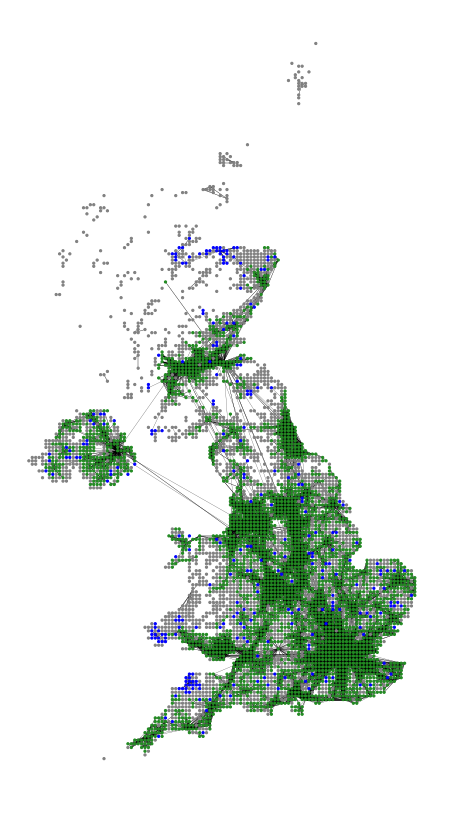

In [15]:
# Visualise LSCC in G
fig, ax = plt.subplots(1,figsize =(8,15))
nx.draw(remove_self_loops(G), ax=ax,pos=geom_dict_numbers,node_size=5, width = 0.2,  arrows=False,
       node_color = visualse_largest_components(G),cmap =newcmp)
plt.show()
fig.savefig(root_figure+'lscc_in_base.svg', dpi=10,bbox_inches='tight')

In [16]:
# Create GeoDataFrame for LSCC nodes
quadkeys = list(lscc.nodes())
polys = []

# Iterate over all quadkeys to create corresponding polygons
for quadkey in quadkeys:
    tile = mercantile.feature(mercantile.quadkey_to_tile(quadkey), projected = 'web mercator')
    polys.append(tile.get('geometry'))
geom = [shape(i) for i in polys]
gdf_lscc = gpd.GeoDataFrame({'geometry':geom, 'quadkey':quadkeys}, crs = "EPSG:4326")
gdf_lscc = gdf_lscc.to_crs("EPSG:3395")

# Import NUTS shape files
map_gdf = gpd.read_file(root_map)
map_gdf = map_gdf.to_crs("EPSG:3395")

# Get NUTS3 
cols = [0,2,3,4,5,6,7,8]
gdf_NUTS3 = map_gdf.drop(map_gdf.columns[cols],axis=1)
gdf_NUTS3.rename(columns={'nuts318cd': 'nuts'}, inplace=True)

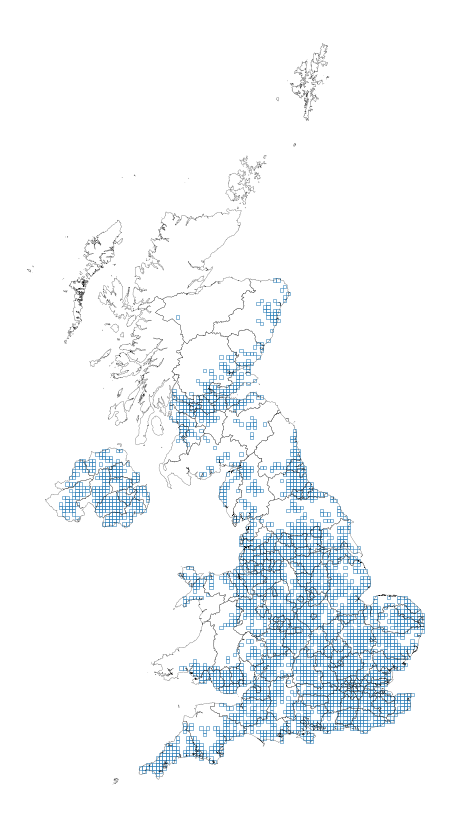

In [17]:
fig, ax = plt.subplots(1,figsize =(10,15))
gdf_NUTS3.boundary.plot(linewidth=0.2, ax=ax, color = 'black')
gdf_lscc.plot(ax=ax, linewidth = 0.5, edgecolor='tab:blue', facecolor = 'none',)
ax.set_axis_off()
fig.savefig(root_figure+'lscc_NUTS3.eps', dpi=fig.dpi,bbox_inches='tight')

## Construction of daily networks

In [ ]:
# Reads in the timeseries of between tiles movement data
df = pd.read_csv(root_timeseries_data)

# Converting the quadkeys to strings
df['start_quadkey'] = df['start_quadkey'].astype(str)
df['end_quadkey'] = df['end_quadkey'].astype(str)
# adding a leading '0' to quadkeys beginning with 3 so it maps on to web mercator
df.loc[df['start_quadkey'].str[:1] == '3', 'start_quadkey'] = '0'+df['start_quadkey']
df.loc[df['end_quadkey'].str[:1] == '3', 'end_quadkey'] = '0'+df['end_quadkey']

# Replace nan by 0
df = df.fillna(0)

###################################
# Filtering out rows outside LSCC #
###################################

# Get LSCC quadkeys
quadkeys_timeseries_LSCC = set(lscc_dict.keys())

df_filtered = df.copy()

for i in range(df.shape[0]):

    start_included =  df.iloc[i]['start_quadkey'] in quadkeys_timeseries_LSCC
    end_included = df.iloc[i]['end_quadkey'] in quadkeys_timeseries_LSCC 
    included = start_included + end_included

    if included != 2:
        df_filtered = df_filtered.drop([i])

print('Number of deleted rows:', df.shape[0] - df_filtered.shape[0])

df = df_filtered.reset_index(drop=True)

#####################################
# Generate daily DiGraphs from data #
#####################################

# Get the first two quadkey columns
df_key = df.iloc[:,:2]

M = df.shape[1]-3
networks = []

for i in range(1,M,3):

    # Get daily data 
    df_mov = df.iloc[:,i+1:i+4]
    df_sum = pd.Series(df_mov.sum(axis=1),name='movement')
    df_sum = pd.concat([df_key,df_sum],axis=1)

    # Generate DiGraph 
    N = len(df_sum)
    G = nx.DiGraph()
    # for each row, add nodes and weighted edge
    for j in range(0,N):
        start = df_sum['start_quadkey'][j]
        end = df_sum['end_quadkey'][j]
        weight = df_sum['movement'][j]
        G.add_node(start)
        G.add_node(end)
        if weight > 0.0:
            G.add_weighted_edges_from([(start, end, weight)] )

    # Append DiGraph to list of networks
    networks.append(G)

###########################################
# Permute nodes such that they match LSCC #
###########################################

for i in range(len(networks)):
    networks[i] = rewire_graph(networks[i])
    
########################
# Store daily DiGraphs #
########################

root4 = root_networks +'timeseries_daily_digraphs_lscc.pkl'

# Store data (serialize)
with open(root4, 'wb') as handle:
    pickle.dump(networks, handle, protocol=pickle.HIGHEST_PROTOCOL)